# Loneliness Composite Score (LCS) Mapping for NYC
## ACS 2019-2023 Data

This notebook calculates the Loneliness Composite Score (LCS) using census tract data from NHGIS and creates a choropleth map.

### LCS Formula
```
LCS = 0.30×Living_Alone + 0.15×Marital_Status + 0.20×Disability 
    + 0.15×No_Vehicle + 0.10×Limited_English + 0.10×Poverty
```

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data

In [2]:
# Define paths
data_dir = Path('../data')
nhgis_dir = data_dir / 'nhgis0008_csv'
shapefile_dir = data_dir / 'tl_2023_36_tract'

# Load census datasets
ds267 = pd.read_csv(nhgis_dir / 'nhgis0008_ds267_20235_tract.csv', encoding='latin1')
ds268 = pd.read_csv(nhgis_dir / 'nhgis0008_ds268_20235_tract.csv', encoding='latin1')

print(f"ds267 shape: {ds267.shape}")
print(f"ds268 shape: {ds268.shape}")

# Merge census datasets on GISJOIN
census_data = ds267.merge(ds268, on='GISJOIN', suffixes=('', '_ds268'))
print(f"\nMerged census data shape: {census_data.shape}")
print(f"Total census tracts in NY State: {len(census_data)}")

ds267 shape: (5396, 410)
ds268 shape: (5396, 296)

Merged census data shape: (5396, 705)
Total census tracts in NY State: 5396


In [3]:
# Load shapefile
gdf = gpd.read_file(shapefile_dir / 'tl_2023_36_tract.shp')
print(f"Shapefile shape: {gdf.shape}")
print(f"CRS: {gdf.crs}")

# Create GISJOIN in shapefile format to match census data
# GISJOIN format: "G" + STATEFP + "0" + COUNTYFP + "0" + TRACTCE
gdf['GISJOIN'] = 'G' + gdf['STATEFP'] + '0' + gdf['COUNTYFP'] + '0' + gdf['TRACTCE']

print(f"\nSample GISJOIN from shapefile: {gdf['GISJOIN'].iloc[0]}")
print(f"Sample GISJOIN from census: {census_data['GISJOIN'].iloc[0]}")

Shapefile shape: (5411, 14)
CRS: EPSG:4269

Sample GISJOIN from shapefile: G3600930033102
Sample GISJOIN from census: G3600010000100


## 2. Filter for NYC Only

NYC consists of 5 counties (boroughs):
- Bronx: County 005
- Kings (Brooklyn): County 047
- New York (Manhattan): County 061
- Queens: County 081
- Richmond (Staten Island): County 085

In [4]:
# Filter for NYC counties
# COUNTYA is integer type, COUNTYFP is string type
nyc_counties_int = [5, 47, 61, 81, 85]  # For census data (integers)
nyc_counties_str = ['005', '047', '061', '081', '085']  # For shapefile (strings)

census_data_nyc = census_data[census_data['COUNTYA'].isin(nyc_counties_int)].copy()
gdf_nyc = gdf[gdf['COUNTYFP'].isin(nyc_counties_str)].copy()

print(f"NYC census tracts: {len(census_data_nyc)}")
print(f"NYC shapefile tracts: {len(gdf_nyc)}")
print(f"\nCounty distribution:")
print(census_data_nyc['COUNTY'].value_counts())

NYC census tracts: 2327
NYC shapefile tracts: 2327

County distribution:
COUNTY
Kings County       805
Queens County      725
Bronx County       361
New York County    310
Richmond County    126
Name: count, dtype: int64


## 3. Calculate LCS Components

### Variable Mapping:
- **Living_Alone**: ASOWE008 / ASOWE001
- **Marital_Status** (not married): (Widowed + Divorced + Separated) / Total 15+
- **Disability**: Sum of all disability flags / Total population
- **No_Vehicle**: AS3PE002 / AS3PE001
- **Limited_English**: (ASQGE004 + ASQGE007 + ASQGE010 + ASQGE013) / ASQGE001
- **Poverty**: AS6WE002 / AS6WE001

In [5]:
# 1. Living Alone (% of households)
census_data_nyc['Living_Alone'] = census_data_nyc['ASOWE008'] / census_data_nyc['ASOWE001']

# 2. Marital Status (% not married: widowed, divorced, separated)
marital_not_married = (
    census_data_nyc['ASPPE009'] +  # Male: Widowed
    census_data_nyc['ASPPE010'] +  # Male: Divorced
    census_data_nyc['ASPPE007'] +  # Male: Separated
    census_data_nyc['ASPPE018'] +  # Female: Widowed
    census_data_nyc['ASPPE019'] +  # Female: Divorced
    census_data_nyc['ASPPE016']    # Female: Separated
)
census_data_nyc['Marital_Status'] = marital_not_married / census_data_nyc['ASPPE001']

# 3. Disability (% with disability)
# Sum all "With a disability" columns from AS78E
disability_cols = [
    'AS78E004', 'AS78E007', 'AS78E010', 'AS78E013', 'AS78E016', 'AS78E019',  # Male
    'AS78E023', 'AS78E026', 'AS78E029', 'AS78E032', 'AS78E035', 'AS78E038'   # Female
]
census_data_nyc['Disability'] = census_data_nyc[disability_cols].sum(axis=1) / census_data_nyc['AS78E001']

# 4. No Vehicle (% of households)
census_data_nyc['No_Vehicle'] = census_data_nyc['AS3PE002'] / census_data_nyc['AS3PE001']

# 5. Limited English (% of households)
limited_english = (
    census_data_nyc['ASQGE004'] +  # Spanish
    census_data_nyc['ASQGE007'] +  # Other Indo-European
    census_data_nyc['ASQGE010'] +  # Asian and Pacific Island
    census_data_nyc['ASQGE013']    # Other languages
)
census_data_nyc['Limited_English'] = limited_english / census_data_nyc['ASQGE001']

# 6. Poverty (% of population)
census_data_nyc['Poverty'] = census_data_nyc['AS6WE002'] / census_data_nyc['AS6WE001']

print("LCS components calculated successfully")
print("\nSummary statistics:")
components = ['Living_Alone', 'Marital_Status', 'Disability', 'No_Vehicle', 'Limited_English', 'Poverty']
print(census_data_nyc[components].describe())

LCS components calculated successfully

Summary statistics:
       Living_Alone  Marital_Status   Disability   No_Vehicle  \
count   2232.000000     2243.000000  2240.000000  2232.000000   
mean       0.297467        0.160668     0.117000     0.485866   
std        0.136511        0.062837     0.068588     0.244175   
min        0.000000        0.000000     0.000000     0.000000   
25%        0.199896        0.119618     0.076006     0.272881   
50%        0.285249        0.156269     0.105135     0.506049   
75%        0.379672        0.198234     0.144543     0.690288   
max        1.000000        1.000000     1.000000     1.000000   

       Limited_English      Poverty  
count      2232.000000  2239.000000  
mean          0.142583     0.168298  
std           0.133003     0.124009  
min           0.000000     0.000000  
25%           0.040186     0.077331  
50%           0.103681     0.137425  
75%           0.213293     0.227032  
max           1.000000     1.000000  


In [6]:
# Handle missing/invalid values
for col in components:
    # Replace inf and -inf with NaN
    census_data_nyc[col] = census_data_nyc[col].replace([np.inf, -np.inf], np.nan)
    # Fill NaN with 0 (tract with no data)
    census_data_nyc[col] = census_data_nyc[col].fillna(0)
    # Clip to [0, 1] range
    census_data_nyc[col] = census_data_nyc[col].clip(0, 1)

print("Missing values handled")
print(f"\nRemaining NaN values per component:")
print(census_data_nyc[components].isna().sum())

Missing values handled

Remaining NaN values per component:
Living_Alone       0
Marital_Status     0
Disability         0
No_Vehicle         0
Limited_English    0
Poverty            0
dtype: int64


## 4. Calculate LCS Score

In [7]:
# Calculate LCS with literature-backed weights
weights = {
    'Living_Alone': 0.30,
    'Marital_Status': 0.15,
    'Disability': 0.20,
    'No_Vehicle': 0.15,
    'Limited_English': 0.10,
    'Poverty': 0.10
}

census_data_nyc['LCS'] = (
    weights['Living_Alone'] * census_data_nyc['Living_Alone'] +
    weights['Marital_Status'] * census_data_nyc['Marital_Status'] +
    weights['Disability'] * census_data_nyc['Disability'] +
    weights['No_Vehicle'] * census_data_nyc['No_Vehicle'] +
    weights['Limited_English'] * census_data_nyc['Limited_English'] +
    weights['Poverty'] * census_data_nyc['Poverty']
)

print("LCS Score Statistics:")
print(census_data_nyc['LCS'].describe())
print(f"\nWeight verification (should sum to 1.0): {sum(weights.values())}")

LCS Score Statistics:
count    2327.000000
mean        0.231126
std         0.093039
min         0.000000
25%         0.171882
50%         0.234335
75%         0.293298
max         0.675559
Name: LCS, dtype: float64

Weight verification (should sum to 1.0): 0.9999999999999999


## 5. Merge with Shapefile

In [8]:
# Merge census data with shapefile
gdf_lcs = gdf_nyc.merge(
    census_data_nyc[['GISJOIN', 'LCS'] + components], 
    on='GISJOIN', 
    how='left'
)

print(f"Merged GeoDataFrame shape: {gdf_lcs.shape}")
print(f"Tracts with LCS scores: {gdf_lcs['LCS'].notna().sum()}")
print(f"Tracts without LCS scores: {gdf_lcs['LCS'].isna().sum()}")

# Check for any missing matches
if gdf_lcs['LCS'].isna().any():
    print("\nWarning: Some tracts have no LCS scores")
    print(gdf_lcs[gdf_lcs['LCS'].isna()][['GEOID', 'NAMELSAD']])

Merged GeoDataFrame shape: (2327, 22)
Tracts with LCS scores: 2327
Tracts without LCS scores: 0


## 6. Create Loneliness Map

Map saved as 'LCS_Map_NYC_2023.png'


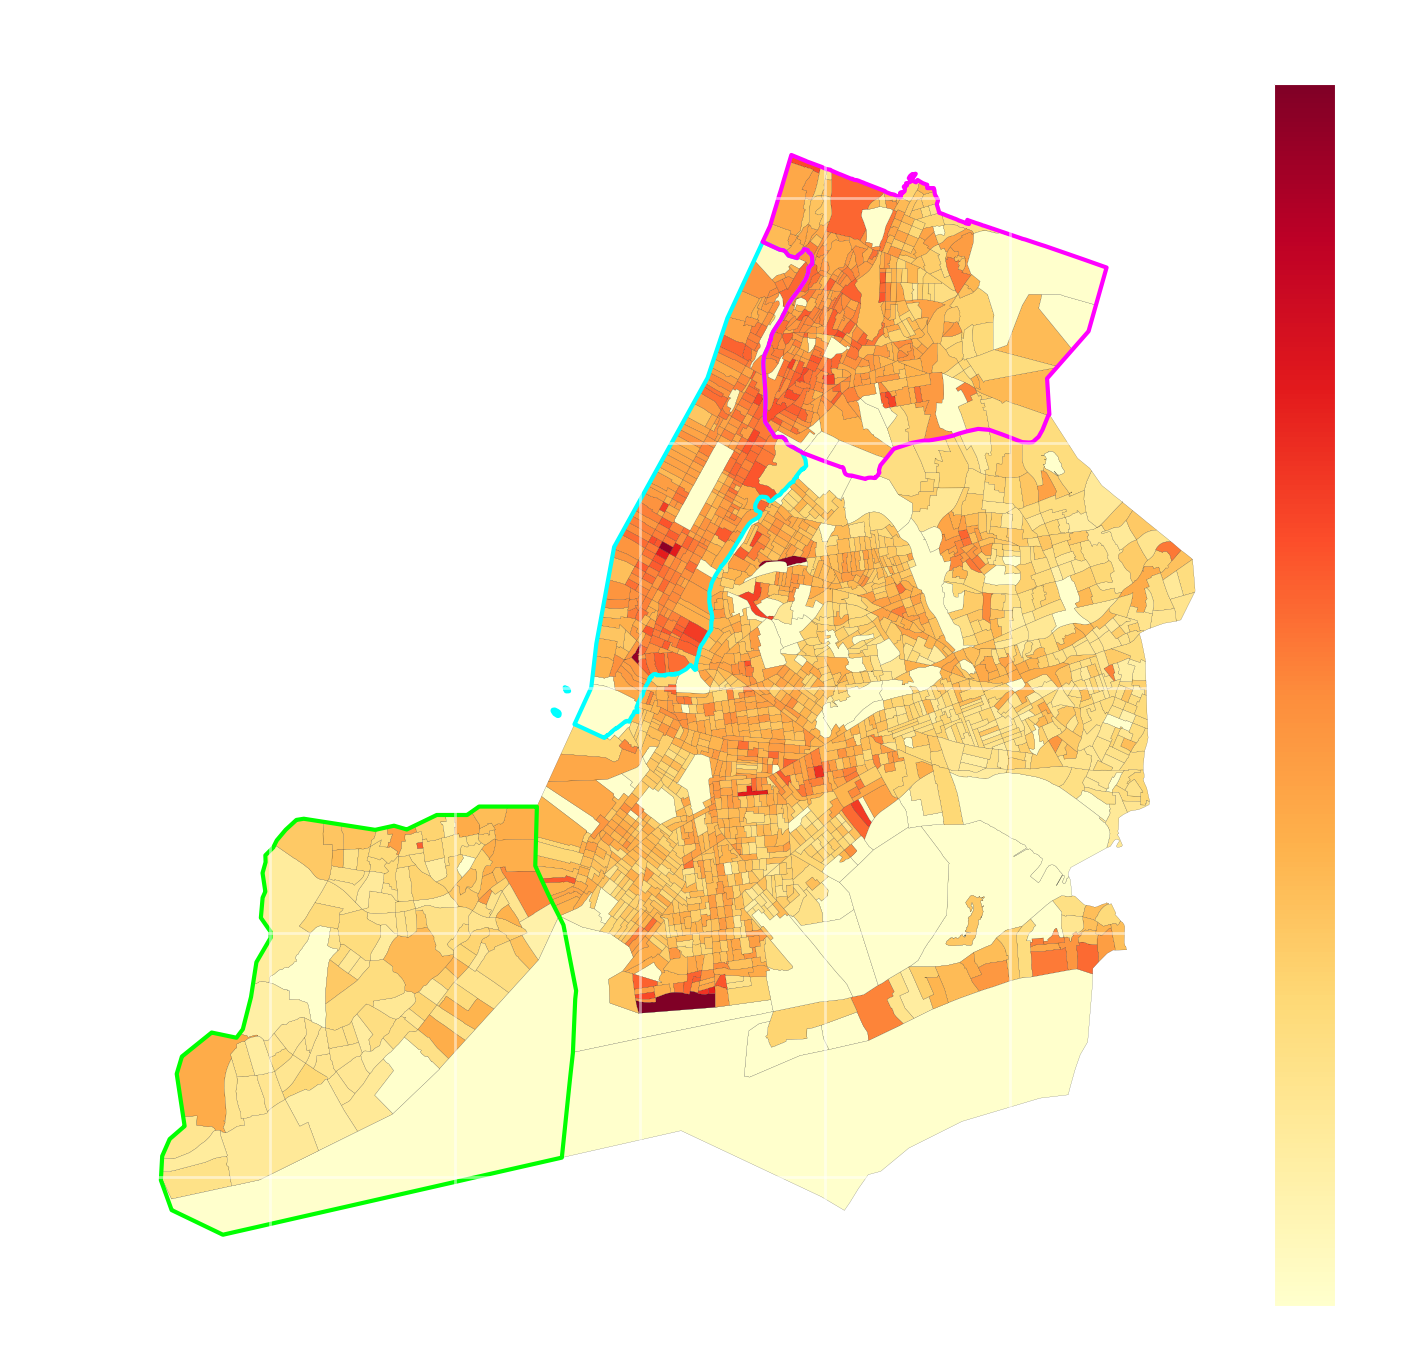

In [18]:
# Create figure with transparent background
fig, ax = plt.subplots(1, 1, figsize=(15, 20))
fig.patch.set_alpha(0)  # Transparent figure background
ax.patch.set_alpha(0)   # Transparent axes background

# Plot LCS
gdf_lcs.plot(
    column='LCS',
    ax=ax,
    legend=True,
    cmap='YlOrRd',
    edgecolor='black',
    linewidth=0.1,
    legend_kwds={
        'label': 'Loneliness Composite Score (LCS)',
        'orientation': 'vertical',
        'shrink': 0.62,
        'aspect': 20,
        'pad': 0.02
    },
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

# Create borough outlines - plot first so they appear under the map edges
# Manhattan (061) - Cyan
manhattan = gdf_lcs[gdf_lcs['COUNTYFP'] == '061'].dissolve()
manhattan.plot(ax=ax, facecolor='none', edgecolor='cyan', linewidth=3)

# Staten Island (085) - Bright Green (lime)
staten_island = gdf_lcs[gdf_lcs['COUNTYFP'] == '085'].dissolve()
staten_island.plot(ax=ax, facecolor='none', edgecolor='lime', linewidth=3)

# Bronx (005) - Magenta
bronx = gdf_lcs[gdf_lcs['COUNTYFP'] == '005'].dissolve()
bronx.plot(ax=ax, facecolor='none', edgecolor='magenta', linewidth=3)

# Styling with larger fonts and white text for dark background
ax.set_title('Loneliness Composite Score (LCS) - NYC Census Tracts\nACS 2019-2023', 
             fontsize=24, fontweight='bold', pad=20, color='white')
ax.set_xlabel('Longitude', fontsize=20, color='white')
ax.set_ylabel('Latitude', fontsize=20, color='white')
ax.tick_params(axis='both', labelsize=18, colors='white')
ax.axis('on')
ax.grid(True, alpha=0.5, color='white', linewidth=2)

# Set spine colors to white
for spine in ax.spines.values():
    spine.set_color('white')

# Make colorbar label larger with white text
cbar = ax.get_figure().axes[-1]  # Get colorbar axis
cbar.tick_params(labelsize=18, colors='white')
cbar.set_ylabel('Loneliness Composite Score (LCS)', fontsize=20, color='white')
cbar.yaxis.label.set_color('white')
for spine in cbar.spines.values():
    spine.set_color('white')

plt.tight_layout()
plt.savefig('../Pitch2/LCS_Map_NYC_2023.png', dpi=300, bbox_inches='tight', transparent=True)
print("Map saved as 'LCS_Map_NYC_2023.png'")
plt.show()

## 7. Additional Analysis

In [10]:
# Borough labels mapping
borough_labels = {
    '005': 'Bronx',
    '047': 'Brooklyn',
    '061': 'Manhattan',
    '081': 'Queens',
    '085': 'Staten Island'
}

# Summary by borough
borough_summary = gdf_lcs.groupby('COUNTYFP')['LCS'].agg(['mean', 'median', 'std', 'min', 'max'])
borough_summary.index = borough_summary.index.map(borough_labels)
print("\nLCS Statistics by Borough:")
print(borough_summary.round(3))


LCS Statistics by Borough:
                mean  median    std  min    max
COUNTYFP                                       
Bronx          0.276   0.288  0.089  0.0  0.443
Brooklyn       0.231   0.235  0.077  0.0  0.676
Manhattan      0.320   0.324  0.078  0.0  0.654
Queens         0.185   0.182  0.080  0.0  0.654
Staten Island  0.154   0.141  0.065  0.0  0.399


Component distributions saved


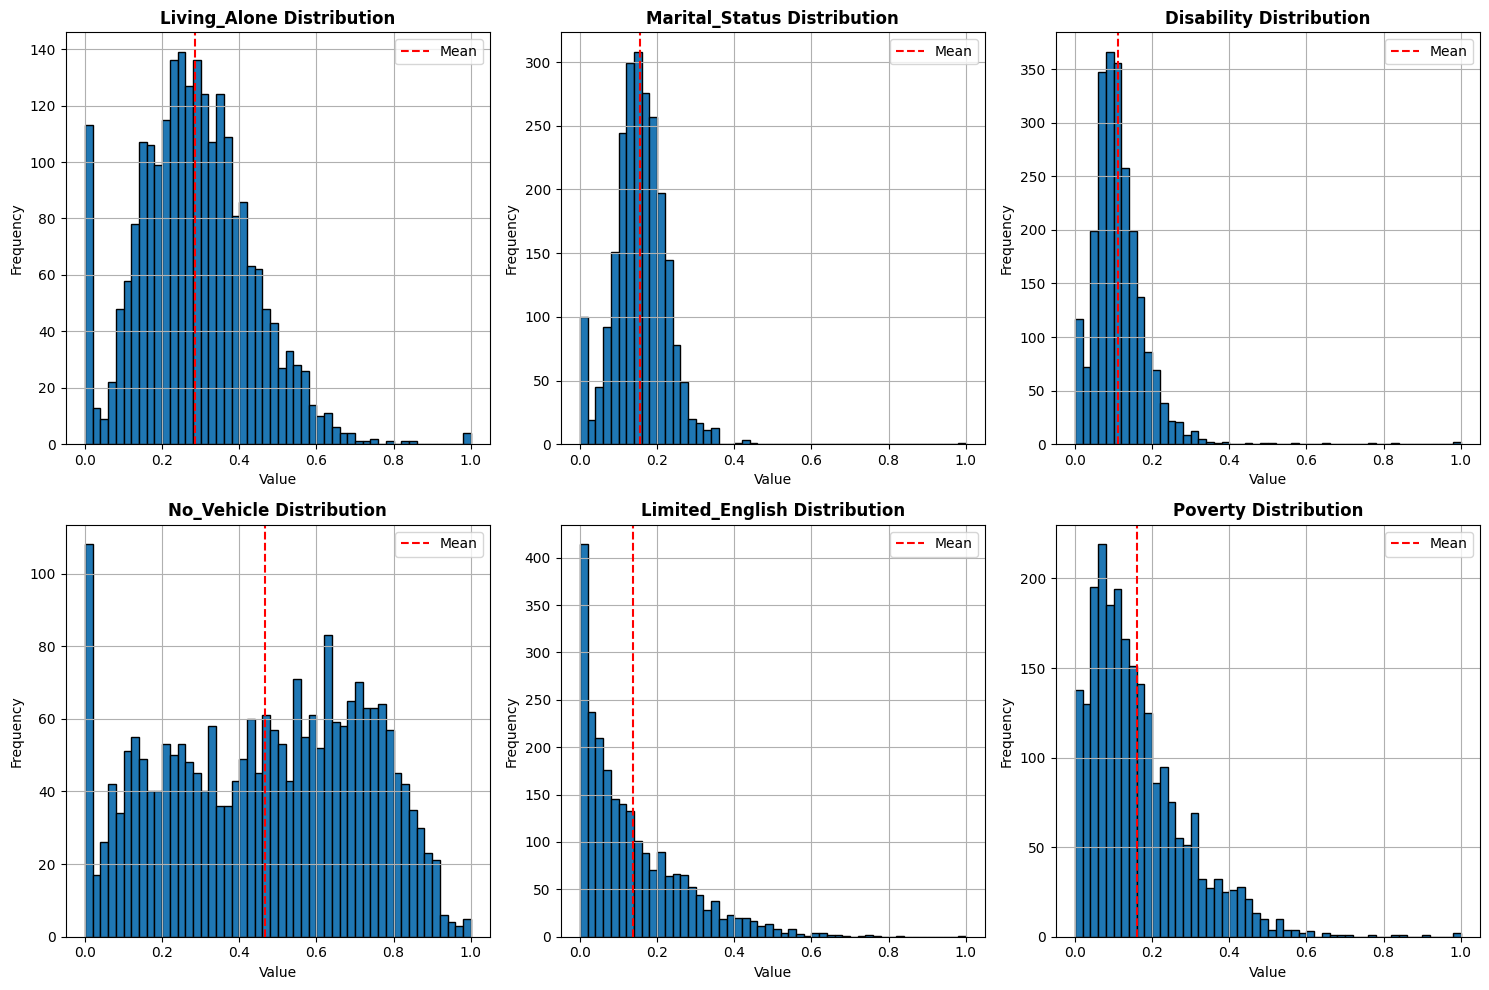

In [11]:
# Distribution histogram
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, component in enumerate(components):
    gdf_lcs[component].hist(ax=axes[idx], bins=50, edgecolor='black')
    axes[idx].set_title(f'{component} Distribution', fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(gdf_lcs[component].mean(), color='red', linestyle='--', label='Mean')
    axes[idx].legend()

plt.tight_layout()
plt.savefig('../Pitch2/LCS_Components_Distribution.png', dpi=300, bbox_inches='tight')
print("Component distributions saved")
plt.show()

In [12]:
# Top 10 highest LCS tracts
print("\nTop 10 Census Tracts with Highest Loneliness Risk:")
top_10 = gdf_lcs.nlargest(10, 'LCS')[['NAMELSAD', 'COUNTYFP', 'LCS'] + components]
top_10['Borough'] = top_10['COUNTYFP'].map(borough_labels)
print(top_10[['NAMELSAD', 'Borough', 'LCS'] + components].to_string())


Top 10 Census Tracts with Highest Loneliness Risk:
                 NAMELSAD    Borough       LCS  Living_Alone  Marital_Status  Disability  No_Vehicle  Limited_English   Poverty
1135     Census Tract 352   Brooklyn  0.675559      0.832865        0.423331    0.571558    0.835674         0.647472  0.577899
525   Census Tract 171.02     Queens  0.653880      1.000000        0.090909    0.000000    1.000000         1.000000  0.902439
1995     Census Tract 119  Manhattan  0.653810      0.983398        0.331010    0.511073    0.973633         0.120117  0.488676
1907   Census Tract 29.01  Manhattan  0.644660      0.670886        0.096324    0.778761    0.860759         0.670886  0.769912
1985      Census Tract 96  Manhattan  0.505740      0.859756        0.170391    0.172996    0.884146         0.262195  0.288136
692      Census Tract 113  Manhattan  0.503761      0.794118        0.221311    0.155738    0.794118         0.205882  0.614754
51       Census Tract 808   Brooklyn  0.502794      

In [13]:
# Save processed data
output_file = '../Pitch2/LCS_NYC_2023.geojson'
gdf_lcs[['GEOID', 'NAMELSAD', 'COUNTYFP', 'LCS'] + components + ['geometry']].to_file(
    output_file, driver='GeoJSON'
)
print(f"\nProcessed data saved to: {output_file}")


Processed data saved to: ../Pitch2/LCS_NYC_2023.geojson
